In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO
import jaxwt as jwt
import pcax
from jax.scipy.stats import norm, laplace

In [2]:
def fourier_sample(rng, n, p, n_freq = 20, intercept = True):
    x = jnp.linspace(0, 1, p)
    f = 0
    for i in range(n_freq):
        rng, key1, key2 = random.split(rng, 3)
        
        an = 1/(n_freq+1) * random.normal(key1, (n, 1))
        bn = 1/(n_freq+1) * random.normal(key2, (n, 1))

        f += an * jnp.cos(2*math.pi * i * x)[None,]
        f += bn * jnp.sin(2*math.pi * i * x)[None,]

    if intercept:
        f += random.normal(rng, (n, 1))
    return f

In [3]:
n, p = 500, 100
bias = 1
beta = random.normal(random.PRNGKey(0), (3,))
sigma = 1.25 + jnp.sin(2 * jnp.pi * jnp.linspace(0, 1, n))[:,None]
mu = jnp.sin(2 * jnp.pi * jnp.linspace(0, 1, n))[:,None]

# mu = mu * jnp.sin(2 * jnp.pi * jnp.linspace(0, 1, p))
n_freq = 20

## train
rng = random.PRNGKey(0)
key1, key2 = random.split(rng)

xtrain = mu + fourier_sample(key1, n, p, n_freq, False)
epsilon = sigma * fourier_sample(key2, n, p, n_freq, False)
ytrain = bias + conv(xtrain, beta) + epsilon

xtrain = xtrain[:,None]
ytrain = ytrain[:,None]

## train
rng = random.PRNGKey(1)
key1, key2 = random.split(rng)

xval = mu + fourier_sample(key1, n, p, n_freq, False)
epsilon = sigma * fourier_sample(key2, n, p, n_freq, False)
yval = bias + conv(xval, beta) + epsilon

xval = xval[:,None]
yval = yval[:,None]

In [4]:
def conv(x, k):
    return jnp.convolve(x, k, mode = 'valid')
conv = jit(vmap(conv, (0, None)))
kernel = jnp.ones(5)/5

rng0 = 0
key1 = random.PRNGKey(rng0 + 1)
key2 = random.PRNGKey(rng0 + 2)
key3 = random.PRNGKey(rng0 + 3)

t = jnp.linspace(0, 1, 108)
s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.sin(s)

f = jnp.sin(2 * math.pi * t)
f = 10 + amp[:,None] * f[None,:]

xtrain = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key1, f.shape)
xtrain = conv(conv(xtrain.squeeze(), kernel), kernel)
xtrain, ytrain = split_data(xtrain, 1, 1)

xval = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key2, f.shape)
xval = conv(conv(xval.squeeze(), kernel), kernel)
xval, yval = split_data(xval, 1, 1)

In [5]:
train_data = TensorDataset(jax2torch(xtrain), jax2torch(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [6]:
loss_fn = nn.MSELoss()

fno = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()
        
with torch.no_grad():
    yval_fno = jnp.array(np.array(fno(jax2torch(xval)).squeeze()))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [7]:
def phi_depth(z, x, w, depth_fn):
    if depth_fn == 'tukey':
        f = jnp.sum(w[:,None] * (z > x), axis = 0)
        depth_1d = 1 - jnp.abs(1 - 2 * f)
    
    elif depth_fn == 'mahal':
        mu = jnp.sum(w[:,None]*x, axis = 0)
        sig = jnp.sqrt(jnp.sum((w[:,None]*x - mu)**2, axis = 0))
        depth_1d = 1/(1+jnp.sqrt((z - mu)**2/sig**2))
        
    elif depth_fn == 'norm':
        norms = jnp.abs(z - x)
        wnorm = jnp.sum(w[:,None] * norms, axis = 0)
        depth_1d = 1/(1+wnorm)

    else: return 0
    return jnp.min(depth_1d)

phi_depth = jit(phi_depth, static_argnames='depth_fn')
vphi_depth = jit(vmap(phi_depth, (0, None, None, None)), static_argnames='depth_fn')

def phi_slice(rng, p1, p2):
    phi = random.normal(rng, (p1, p2))
    phi = phi / jnp.sum(phi, axis = 1)[:,None]
    return phi

def lweights(xval, xtest, frac = 0.1):
    dmat = jnp.max(jnp.abs(xval - xtest), axis = 1)
    quant = jnp.quantile(dmat, frac, axis = 0)
    indx = dmat < quant
    inner_max = jnp.max(dmat * indx)
    dmat = inner_max - dmat
    w = dmat * indx
    return w / jnp.sum(w, axis = 0)[None,]
lweights = jit(vmap(lweights, (None, 0, None)))

def phi_quantile(rval_phi, xval, xtest, alpha, depth_fn, lam, rng):
    
    xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
    dist = jnp.exp(-lam * jnp.max(jnp.abs(xval - xtil), axis = (1, 2)))
    local_weights = dist / (jnp.sum(dist) + jnp.exp(-lam * 1e-2))

    dval = vphi_depth(rval_phi, rval_phi, local_weights, depth_fn)
    
    n = xval.shape[0]
    adj_alpha = jnp.ceil((n+1)*(1-alpha))/n
    return jnp.quantile(dval, 1-adj_alpha), local_weights
phi_quantile = jit(phi_quantile, static_argnames='depth_fn')


def phi_resample(xval, xtest, rval_phi, n_samp, n_slice, rng,
                 alpha, depth_fn, lam):
    n = rval_phi.shape[0]
    npc = rval_phi.shape[1]
    key1, key2, key3 = random.split(rng, 3)
    local_weights = lweights(xval.squeeze(), 
                             xtest.squeeze()[None,], 0.1)[0]
    
    unif = random.uniform(key1, (n_samp, npc))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    samp_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    samp_quants = jnp.argmax(samp_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    samp_phi = quants[samp_quants].T
    
    phi = phi_slice(key2, npc, n_slice)
    qval, local_weights = phi_quantile(rval_phi @ phi, xval, xtest, alpha, depth_fn, lam, rng = key3)
    dphi = vphi_depth(samp_phi @ phi, rval_phi @ phi, local_weights, depth_fn)
    
    return samp_phi, dphi, qval

In [8]:
nsim = 1
# cover_lam1 = np.zeros(nsim)
# cover_lam2 = np.zeros(nsim)
# cover_lam3 = np.zeros(nsim)
# cover_lam4 = np.zeros(nsim)
# cover_lam5 = np.zeros(nsim)

cover_lam1 = []
width_lam1 = []

rng = random.PRNGKey(0)
p_dim = 25
p_slice = 100
for i in trange(nsim):
    rng, sub_rng = random.split(rng, 2)
    key1, key2, key3, key4 = random.split(sub_rng, 4)

    xtest = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key3, f.shape)
    xtest = conv(conv(xtest.squeeze(), kernel), kernel)
    xtest, ytest = split_data(xtest, 1, 1)
    
    with torch.no_grad():
        ytest_fno = jnp.array(np.array(fno(jax2torch(xtest)).squeeze()))
        
    rval_fno = yval.squeeze() - yval_fno
    rtest_fno = ytest.squeeze() - ytest_fno
    
    ##### random basis
#     phi = phi_slice(key3, rval_fno.shape[1], p_slice)
#     rval_phi = rval_fno @ phi
#     rtest_phi = rtest_fno @ phi
    
    state = pcax.fit(rval_fno, n_components = p_dim)
    rval_phi = pcax.transform(state, rval_fno)
    rtest_phi = pcax.transform(state, rtest_fno)
    
    cover = []
    width = []
    qvals = []
    for k in trange(xtest.shape[0], leave = False):
        qval, local_weights = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'tukey', 10, rng = key4)
        dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'tukey')
        cover.append(dtest > qval)
        qvals.append(qval)
        
#         r_samp = fourier_sample(rng, n, p)
#         d_samp = vphi_depth(pcax.transform(state, r_samp), rval_phi, local_weights, 'tukey')

#         eta_sig = jnp.sqrt(state[2])
#         eta_samp = random.normal(key4, (2000, p_dim))
#         r_ens = r_samp[d_samp > qval]
#         uval = jnp.max(r_ens, axis = 0)
#         lval = jnp.min(r_ens, axis = 0)
#         width.append(np.mean(uval - lval))

#         eta_sig = jnp.sqrt(state[2])
#         eta_samp = eta_sig[None,] * random.normal(key4, (2000, p_dim))
#         d_samp = vphi_depth(eta_samp[:,None], rval_phi, local_weights, 'tukey')
#         r_ens = pcax.recover(state, eta_samp[d_samp > qval])
#         uval = jnp.max(r_ens, axis = 0)
#         lval = jnp.min(r_ens, axis = 0)
#         width.append(np.mean(uval - lval))
        
    cover_lam1.append(np.array(cover))
    width_lam1.append(np.array(width))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
# eta_sig = jnp.sqrt(state[2])
# eta_samp = eta_sig[None,] * random.normal(key4, (2000, p_dim))
# d_samp = vphi_depth(eta_samp[:,None], rval_phi, local_weights, 'norm')
# r_ens = pcax.recover(state, eta_samp[d_samp > qval])

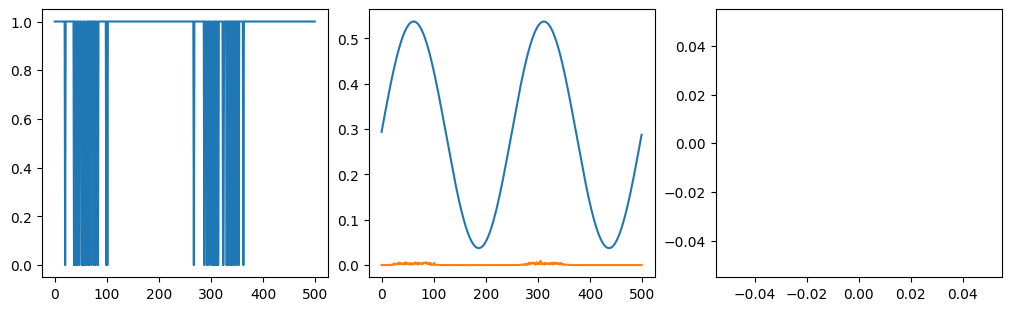

In [10]:
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (10, 3))
ax[0].plot(np.mean(np.stack(cover_lam1), axis = 0))

ax[1].plot(np.array(0.25 * (1.15 + sd[1:])))
ax[1].plot(jnp.array(qvals))

ax[2].plot(np.mean(np.stack(width_lam1), axis = 0))
plt.show()

In [11]:
# np.corrcoef([sd[1:], np.array(qvals)])

In [13]:
# np.corrcoef([sd[1:], np.array(usc1_width)])

In [47]:
def phi_resample(xval, xtest, rval_phi, n_samp, n_slice, rng):
    n = rval_phi.shape[0]
    npc = rval_phi.shape[1]
    key1, key2, key3 = random.split(rng, 3)
    local_weights = lweights(xval.squeeze(), 
                             xtest.squeeze()[None,], 0.1)[0]
    
    unif = random.uniform(key1, (n_samp, npc))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    samp_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    samp_quants = jnp.argmax(samp_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    samp_phi = quants[samp_quants].T
    
    phi = phi_slice(key2, npc, n_slice)
    qval, local_weights = phi_quantile(rval_phi @ phi, xval, xtest, 0.1, 'tukey', 10, rng = key3)
    dphi = vphi_depth(samp_phi @ phi, rval_phi @ phi, local_weights, 'tukey')
    
    return samp_phi, dphi, qval

In [48]:
# phi_resample = jit(phi_resample, static_argnums = (2, 3, 4))

In [49]:
local_ens.shape

(0, 100)

In [51]:
nsamp = 1000
npc = 50
nproj = 25
state = pcax.fit(rval_fno, n_components = npc)
rval_phi = pcax.transform(state, rval_fno)
rtest_phi = pcax.transform(state, rtest_fno)

width = []
usc1_risk = []
usc1_width = []
rng = random.PRNGKey(0)
for k in trange(xtest.shape[0], leave = False):
    
    rng, key1, key2 = random.split(rng, 3)
    
    local_ens, dphi, qval = phi_resample(xval, xtest[k], rval_phi, nsamp, nproj, key1)
    local_ens = pcax.recover(state, local_ens)
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    width.append(np.mean(uval - lval))

    usc1_risk.append(risk(lval, uval, rtest_fno[k]))
    usc1_width.append(jnp.median(uval - lval))

  0%|          | 0/500 [00:00<?, ?it/s]

In [54]:
# # weight = local_weights(xval2, xtest2, gamma).squeeze()

# nsamp = 2000
# npc = 50
# state = pcax.fit(rval_fno, n_components = npc)
# rval_phi = pcax.transform(state, rval_fno)
# rtest_phi = pcax.transform(state, rtest_fno)

# width = []
# usc1_risk = []
# usc1_width = []
# rng = random.PRNGKey(0)
# for k in trange(xtest.shape[0], leave = False):
#     rng, key1, key2 = random.split(rng, 3)

#     qval, local_weights = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'mahal', 10, rng = key1)
#     dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'mahal')

#     unif = random.uniform(key2, (nsamp, npc))
#     quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

#     local_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
#     local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
#     local_phi = quants[local_quants].T

#     dphi = vphi_depth(local_phi, rval_phi, local_weights, 'mahal')

#     local_ens = pcax.recover(state, local_phi)
#     local_ens = local_ens[dphi > qval]

#     uval = jnp.max(local_ens, axis = 0)
#     lval = jnp.min(local_ens, axis = 0)
#     width.append(np.mean(uval - lval))

#     usc1_risk.append(risk(lval, uval, rtest_fno[k]))
#     usc1_width.append(jnp.median(uval - lval))

In [55]:
# # weight = local_weights(xval2, xtest2, gamma).squeeze()

# nsamp = 2000
# npc = 50
# p_slice = 100
# state = pcax.fit(rval_fno, n_components = npc)
# rval_phi = pcax.transform(state, rval_fno)
# rtest_phi = pcax.transform(state, rtest_fno)

# width = []
# usc1_risk = []
# usc1_width = []
# rng = random.PRNGKey(0)
# for k in trange(xtest.shape[0], leave = False):
#     rng, key1, key2, key3 = random.split(rng, 4)

# #     _, local_weights = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'norm', 10, rng = key1)
# #     dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'norm')

#     local_weights = lweights(xval[:,0], xtest[k:(k+1),0], 0.1)[0]

#     unif = random.uniform(key2, (nsamp, npc))
#     quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

#     local_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
#     local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
#     local_phi = quants[local_quants].T
    
#     phi = phi_slice(key3, npc, p_slice)
#     qval, local_weights = phi_quantile(rval_phi @ phi, xval, xtest[k], 0.1, 'tukey', 5, rng = key1)
#     dphi = vphi_depth(local_phi @ phi, rval_phi @ phi, local_weights, 'tukey')

#     local_ens = pcax.recover(state, local_phi)
#     local_ens = local_ens[dphi > qval]

#     uval = jnp.max(local_ens, axis = 0)
#     lval = jnp.min(local_ens, axis = 0)
#     width.append(np.mean(uval - lval))

#     usc1_risk.append(risk(lval, uval, rtest[k]))
#     usc1_width.append(jnp.median(uval - lval))

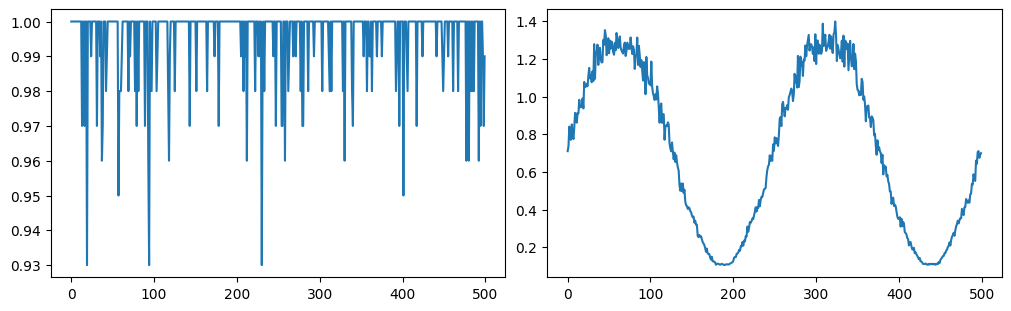

In [56]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 3))
ax[0].plot(usc1_risk)
ax[1].plot(usc1_width)
plt.show()
# np.mean(usc1_risk)

In [73]:
np.mean(np.array(usc1_risk) >= 0.95)

0.994

In [74]:
usc_risk = np.array(np.array(usc1_risk) >= 0.95, dtype = np.int8)

In [77]:
np.corrcoef([sd[1:], usc_risk])

array([[ 1.        , -0.02588357],
       [-0.02588357,  1.        ]])

In [158]:
## coverage gap: shrinks with bandwidth lambda
n = 1000
d0 = np.random.uniform(0, 1, n)
d = d0.copy()
# d[d > np.quantile(d, 0.001)] = np.inf
w = np.exp(-1000*d)
w = w/(1 + np.sum(w))
np.sum(w * d0)/(1 + np.sum(w))

0.00030759216990301573

In [8]:
z = np.random.multivariate_normal(np.zeros(2), np.array([[1, 0.5],[0.5, 2]]), (5000,))
phi = phi_slice(random.PRNGKey(0), 2, 50)
z_phi = z @ phi
d = vphi_depth(z_phi, z_phi, jnp.ones(1)/z.shape[0], 'tukey')

In [9]:
z = np.random.gamma(3, 9, (5000, 2))
phi = phi_slice(random.PRNGKey(0), 2, 50)
z_phi = z @ phi
d = vphi_depth(z_phi, z_phi, jnp.ones(1)/z.shape[0], 'tukey')

In [107]:
z1 = np.random.multivariate_normal(np.zeros(2), np.array([[1, 0.5],[0.5, 2]]), (5000,))

z2 = np.hstack([np.random.gamma(2, 0.5, (5000, 1)),
                np.random.gamma(1, 0.5, (5000, 1))])

phi = phi_slice(random.PRNGKey(0), 2, 50)
d1 = vphi_depth(z1 @ phi, z1 @ phi, jnp.ones(1)/z.shape[0], 'tukey')
d2 = vphi_depth(z2 @ phi, z2 @ phi, jnp.ones(1)/z.shape[0], 'tukey')

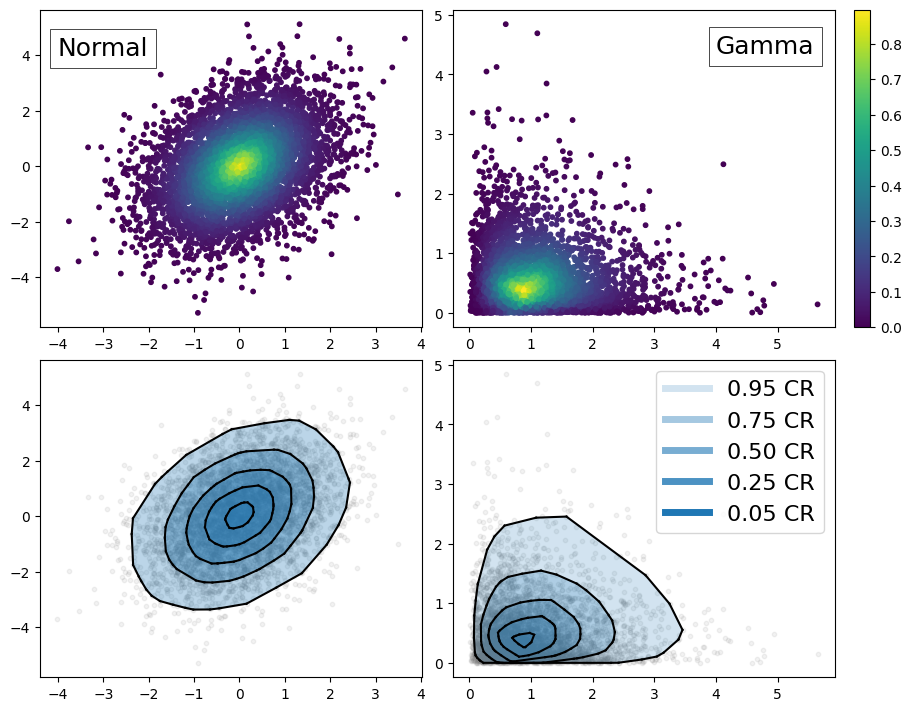

In [132]:
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize = (9, 7))
im = ax[0,0].scatter(z1[:,0], z1[:,1], c = d1, s = 10, alpha = 1, label = 'Normal')
im = ax[0,1].scatter(z2[:,0], z2[:,1], c = d2, s = 10, alpha = 1, cmap = 'viridis', label = 'Gamma')

bbox=dict(boxstyle="square,pad=0.3",fc='white',lw=0.5)
ax[0,0].annotate('Normal', xy=(-4, 4), fontsize = 18, bbox=bbox)
ax[0,1].annotate('Gamma', xy=(4, 4.35), fontsize = 18, bbox=bbox)
cbar = plt.colorbar(im, ax = ax[0,1])
cbar.solids.set(alpha=1)

quants = [0.05, 0.25, 0.5, 0.75, 0.95]
ax[1,0].scatter(z1[:,0], z1[:,1], s = 10, alpha = 0.1, c = 'grey')
for quant in quants:
    z_cr = z1[d1 > np.quantile(d1, 1-quant)]
    hull = ConvexHull(z_cr)
    
    ax[1,0].fill(z_cr[hull.vertices, 0], z_cr[hull.vertices, 1], 'C0', alpha=0.3)
    for simplex in hull.simplices:
        ax[1,0].plot(z_cr[simplex, 0], z_cr[simplex, 1], 'k-')
        

ax[1,1].scatter(z2[:,0], z2[:,1], s = 10, alpha = 0.1, c = 'grey')
k = 1
for quant in quants:
    z_cr = z2[d2 > np.quantile(d1, 1-quant)]
    hull = ConvexHull(z_cr)
    
    ax[1,1].fill(z_cr[hull.vertices, 0], z_cr[hull.vertices, 1], 'C0', alpha = 0.2)
    plt.plot([], [], c = 'C0', alpha = 0.2*k, label = f'{1-quant:.2f} CR')
    for simplex in hull.simplices:
        ax[1,1].plot(z_cr[simplex, 0], z_cr[simplex, 1], 'k-')
    k += 1
        
legend = ax[1,1].legend(fontsize = 16)
[x.set_linewidth(5) for x in legend.get_lines()]
# cbar = plt.colorbar(im, ax = ax[1,1])
# cbar.solids.set(alpha=1)
plt.show()

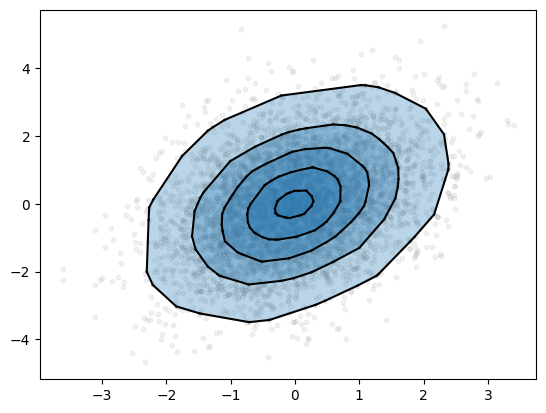

In [83]:
# from scipy.spatial import ConvexHull


# plt.scatter(z1[:,0], z1[:,1], s = 10, alpha = 0.1, c = 'grey')
# quants = [0.05, 0.25, 0.5, 0.75, 0.95]
# for quant in quants:
#     z_cr = z1[d1 > np.quantile(d1, 1-quant)]
#     hull = ConvexHull(z_cr)
    
#     plt.fill(z_cr[hull.vertices, 0], z_cr[hull.vertices, 1], 'C0', alpha=0.3)
#     for simplex in hull.simplices:
#         plt.plot(z_cr[simplex, 0], z_cr[simplex, 1], 'k-')

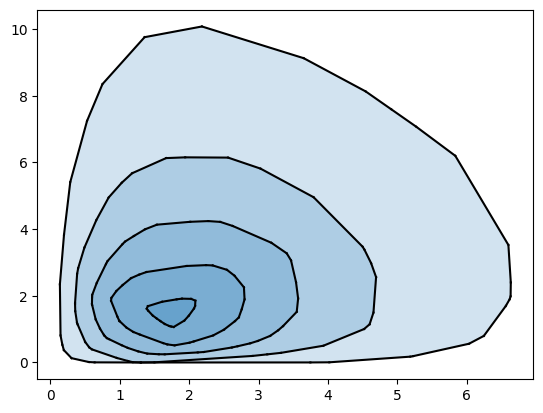

In [80]:
# plt.scatter(z2[:,0], z2[:,1], s = 10, alpha = 0.1, c = 'grey')
k = 0
quants = [0.05, 0.25, 0.5, 0.75, 0.95]
for quant in quants:
    z_cr = z2[d2 > np.quantile(d1, 1-quant)]
    hull = ConvexHull(z_cr)
    
    plt.fill(z_cr[hull.vertices, 0], z_cr[hull.vertices, 1], 'C0', alpha = 0.2)
#     plt.plot([], [], c = 'C0', alpha = )
    for simplex in hull.simplices:
        plt.plot(z_cr[simplex, 0], z_cr[simplex, 1], 'k-')

In [239]:
# weight = local_weights(xval2, xtest2, gamma).squeeze()

state = pcax.fit(rval_fno, n_components = p_dim)
# rval_phi = pcax.transform(state, rval_fno)
# rtest_phi = pcax.transform(state, rtest_fno)

wave_shape = jwt.wavedec(rval_fno, 'haar', mode='zero', level=2)
wave_shape = [a.shape[1] for a in wave_shape]

rval_phi = jwt.wavedec(rval_fno, 'haar', mode='zero', level=2)[0]
rtest_phi = jwt.wavedec(rtest_fno, 'haar', mode='zero', level=2)[0]

nsamp = 2000
npc = p_dim

width = []
usc1_risk = []
usc1_width = []
rng = random.PRNGKey(0)
for k in trange(xtest.shape[0], leave = False):
    rng, key1, key2 = random.split(rng, 3)

    qval, local_weights = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'mahal', 10, rng = key1)
    dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'mahal')

    unif = random.uniform(key2, (nsamp, npc))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    local_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    local_phi = quants[local_quants].T

    dphi = vphi_depth(local_phi, rval_phi, local_weights, 'mahal')

#     local_ens = pcax.recover(state, local_phi)
    local_ens = [local_phi, 
                 0.01*random.normal(key2, (nsamp, wave_shape[1])), 
                 0.01*random.normal(key2, (nsamp, wave_shape[2]))]
    local_ens = jwt.waverec(local_ens, 'haar')
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    width.append(np.mean(uval - lval))

    usc1_risk.append(risk(lval, uval, rtest[k]))
    usc1_width.append(jnp.median(uval - lval))

  0%|          | 0/500 [00:00<?, ?it/s]

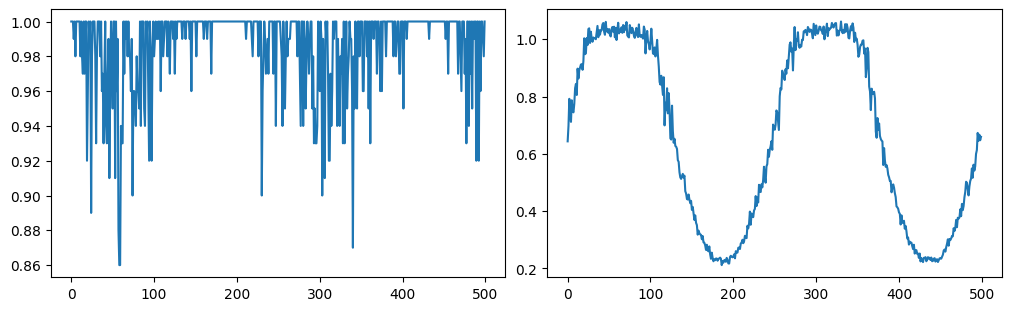

In [240]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 3))
ax[0].plot(usc1_risk)
ax[1].plot(usc1_width)
plt.show()

In [241]:
np.mean(np.array(usc1_risk) >= 0.99)

0.606

In [263]:
# weight = local_weights(xval2, xtest2, gamma).squeeze()

nsamp = 2000
npc = 50
state = pcax.fit(rval_fno, n_components = npc)
rval_phi = pcax.transform(state, rval_fno)
rtest_phi = pcax.transform(state, rtest_fno)

rval_fft = jnp.fft.fft(rval_fno)
rval_real = jnp.real(rval_fft)
rval_imag = jnp.imag(rval_fft)
rval_phi = jnp.hstack([rval_real, rval_imag])

rtest_fft = jnp.fft.fft(rtest_fno)
rtest_real = jnp.real(rtest_fft)
rtest_imag = jnp.imag(rtest_fft)
rtest_phi = jnp.hstack([rtest_real, rtest_imag])

width = []
usc1_risk = []
usc1_width = []
rng = random.PRNGKey(0)
for k in trange(xtest.shape[0], leave = False):
    rng, key1, key2 = random.split(rng, 3)

    qval, local_weights = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'tukey', 10, rng = key1)
    dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'tukey')

    unif = random.uniform(key2, (nsamp, rval_phi.shape[1]))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    local_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    local_phi = quants[local_quants].T

    dphi = vphi_depth(local_phi, rval_phi, local_weights, 'tukey')
    
    local_ens = jax.lax.complex(local_phi[:,:100], local_phi[:,100:])
    local_ens = jnp.real(jnp.fft.ifft(local_ens))
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    width.append(np.mean(uval - lval))

    usc1_risk.append(risk(lval, uval, rtest[k]))
    usc1_width.append(jnp.median(uval - lval))

  0%|          | 0/500 [00:00<?, ?it/s]

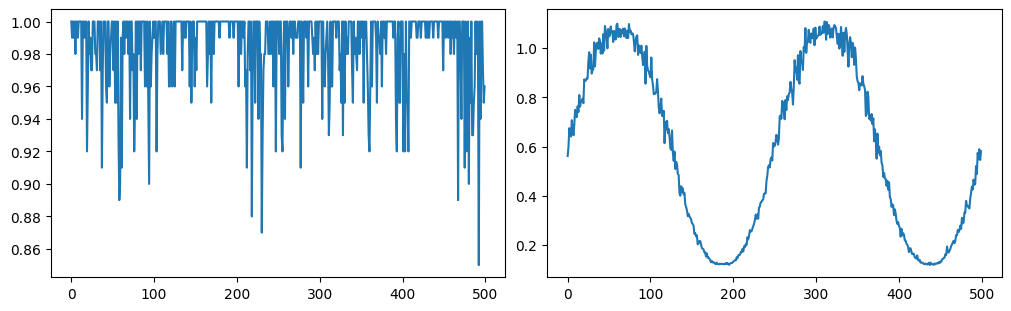

In [264]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 3))
ax[0].plot(usc1_risk)
ax[1].plot(usc1_width)
plt.show()

In [266]:
np.mean(np.array(usc1_risk) >= 0.99)

0.566

In [ ]:
nproj = npc = 200
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

lsc1_risk, lsc1_width = [], []

rval = yval[:,0] - yval_fno
rtest = ytest[:,0] - ytest_fno
state = lsci.lsci_state(xval.reshape(n, -1), rval, npc)
pca_state = state[-1]

for i in trange(0, ytest.shape[0]):
    
    xtest_i = xtest[i].reshape(1, -1)
    rtest_i = rtest[i].reshape(1, -1)
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest_i, state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest_i))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))

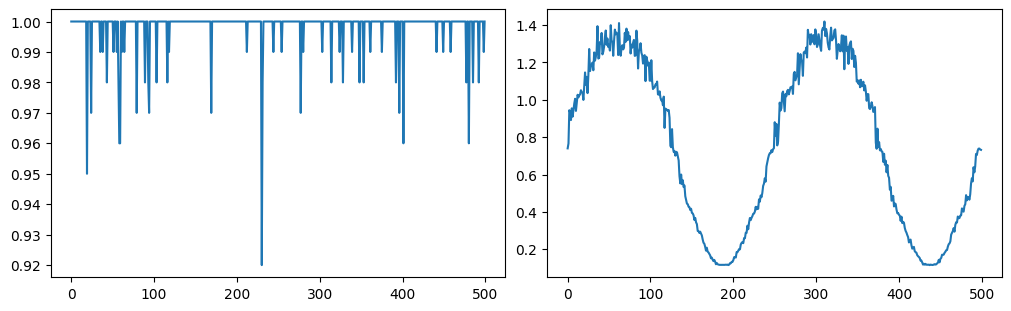

In [20]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 3))
ax[0].plot(lsc1_risk)
ax[1].plot(lsc1_width)
plt.show()

In [235]:
w1 = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'tukey', 10, rng = key4)[1]
w2 = lweights(xval[:,0], xtest[k:(k+1),0], 0.1)[0]

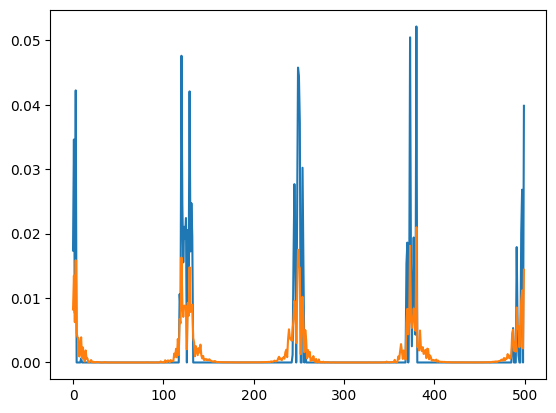

In [237]:
plt.plot(w2)
plt.plot(w1)

In [238]:
def phi_quantile(rval_phi, xval, xtest, alpha, depth_fn, lam, rng):
    
    xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
    dist = jnp.exp(-lam * jnp.max(jnp.abs(xval - xtil), axis = (1, 2)))
    local_weights = dist / (jnp.sum(dist) + jnp.exp(-lam * 1e-2))

#     local_weights = lweights(xval[:,0], xtest, 1/lam)[0]
    dval = vphi_depth(rval_phi, rval_phi, local_weights, depth_fn)
    
    n = xval.shape[0]
    adj_alpha = jnp.ceil((n+1)*(1-alpha))/n
    return jnp.quantile(dval, 1-adj_alpha), local_weights, dval
phi_quantile = jit(phi_quantile, static_argnames='depth_fn')

In [242]:
cover = []

##### random basis
state = pcax.fit(rval_fno, n_components = p_dim)
rval_phi = pcax.transform(state, rval_fno)
rtest_phi = pcax.transform(state, rtest_fno)

k = 1
qval, local_weights, dval = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'norm', 5, rng = key4)
dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'norm')
cover.append(dtest > qval)

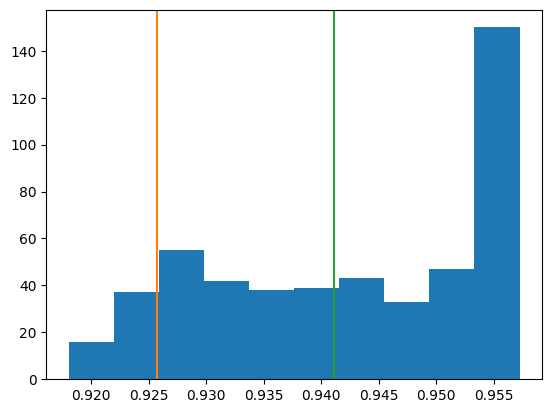

In [243]:
plt.hist(dval)
plt.axvline(qval, c = 'C1')
plt.axvline(dtest, c = 'C2')
plt.show()

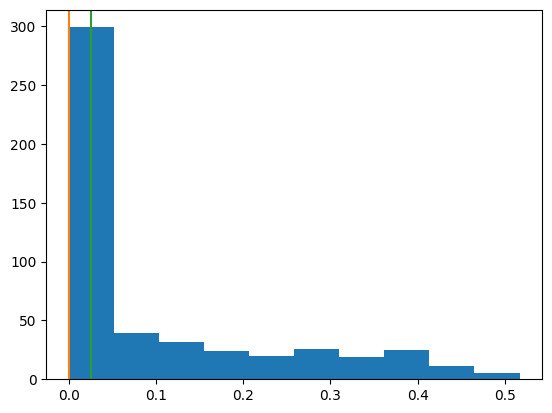

In [57]:
plt.hist(dval)
plt.axvline(qval, c = 'C1')
plt.axvline(dtest, c = 'C2')
plt.show()

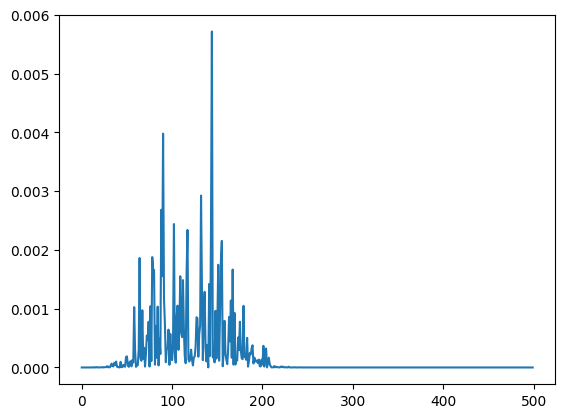

In [380]:
plt.plot(local_weights)

In [255]:
xval_fpca = jnp.stack([jnp.mean(xval, axis = (1, 2)), 
                       jnp.var(xval, axis = (1, 2))]).T
xtest_fpca = jnp.stack([jnp.mean(xtest, axis = (1, 2)), 
                        jnp.var(xtest, axis = (1, 2))]).T

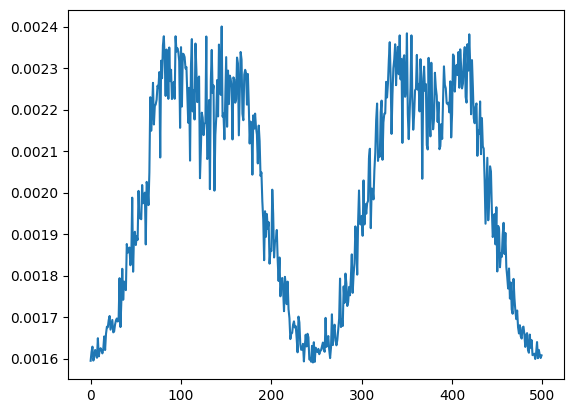

In [257]:
k = 100
qval, local_weights = phi_quantile(rval_phi, xval_fpca[:,None], xtest_fpca[:,None][k], 0.1, 'tukey', 1, rng = key4)
dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'tukey')
plt.plot(local_weights)

In [ ]:
weight = local_weights(xval2, xtest2, gamma).squeeze()
unif = random.uniform(rng, (nsamp, npc))
quants = jnp.linspace(jnp.min(rval2) - 0.1, jnp.max(rval2) + 0.1, nval+1)

local_cdfs = lcdf(rval2, quants, weight)
local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
local_phi = quants[local_quants].T

dval = jnp.mean(local_tukey_self(rval2, rval2, weight), axis = 0) * jnp.min(local_tukey_self(rval2, rval2, weight), axis = 0)
qval = jnp.quantile(dval, alpha)
dphi = jnp.mean(local_tukey_self(rval2, local_phi, weight), axis = 0)

local_ens = pcax.recover(pca_state, local_phi)
local_ens = local_ens[dphi > qval]
return local_ens